In [1]:
import os
from glob import glob

import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns

from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
import os
from glob import glob
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.applications import DenseNet201
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
!git clone https://github.com/lokesh2503/Fusar-classification.git

Cloning into 'Fusar-classification'...
remote: Enumerating objects: 15491, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 15491 (delta 0), reused 7 (delta 0), pack-reused 15483
Receiving objects: 100% (15491/15491), 664.69 MiB | 14.52 MiB/s, done.
Resolving deltas: 100% (124/124), done.
Updating files: 100% (20235/20235), done.


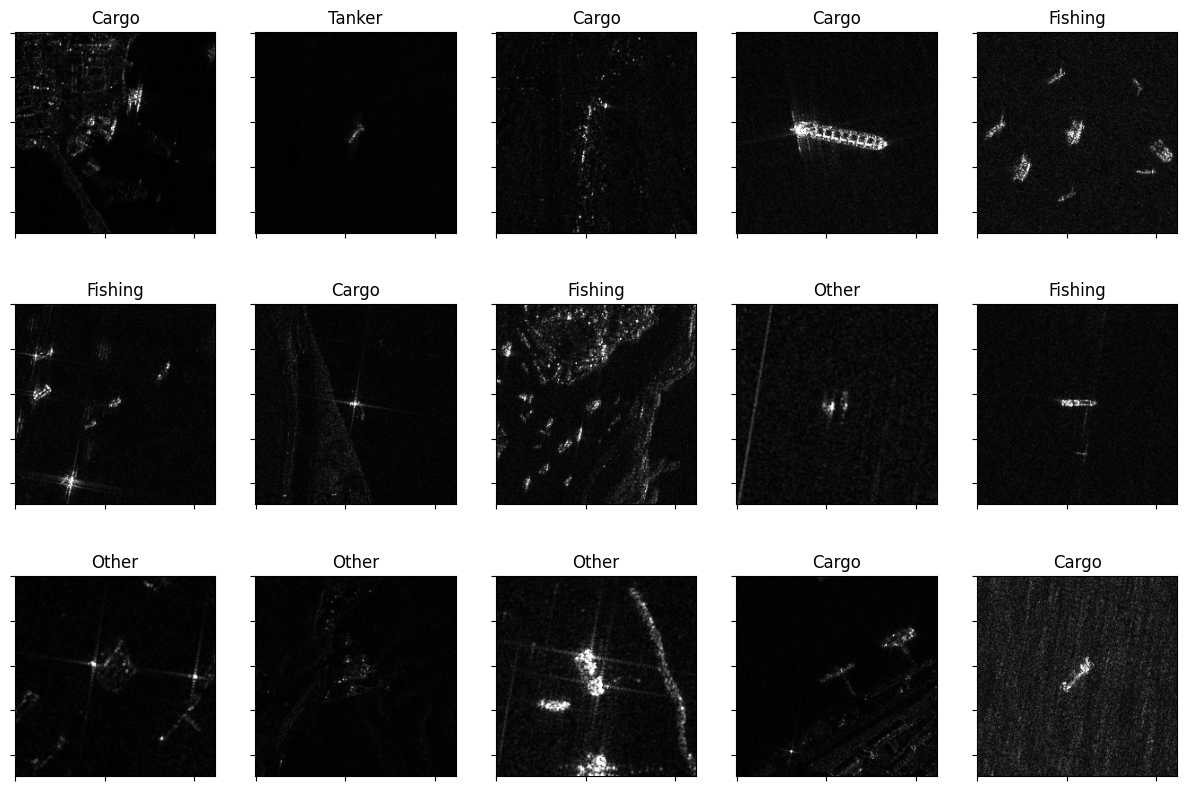

In [4]:
# Set basepath
basepath = "/content/Fusar-classification/before_aug"

# Generate a list of files for each class
files_list_cargo = glob(os.path.join(basepath, "Cargo/*"))
files_list_fishing = glob(os.path.join(basepath, "Fishing/*"))
files_list_tanker = glob(os.path.join(basepath, "Other/*"))
files_list_other = glob(os.path.join(basepath, "Tanker/*"))
files_list_unspecified = glob(os.path.join(basepath, "Unspecified/*"))

# Open the files
images = []
labels = []
text_labels = ['Cargo', 'Fishing', 'Other', 'Tanker', 'Unspecified']

for file in files_list_cargo:
    img_path = os.path.join(basepath, file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    images.append(img)
    labels.append(0)

for file in files_list_fishing:
    img_path = os.path.join(basepath, file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    images.append(img)
    labels.append(1)

for file in files_list_tanker:
    img_path = os.path.join(basepath, file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    images.append(img)
    labels.append(2)

for file in files_list_other:
    img_path = os.path.join(basepath, file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    images.append(img)
    labels.append(3)

for file in files_list_unspecified:
    img_path = os.path.join(basepath, file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    images.append(img)
    labels.append(4)

images = np.array(images, dtype=np.int64)
labels = np.array(labels, dtype=np.int64)

# Split the data into train (70%), validation (20%) and test (10%) datasets
np.random.seed(27)
np.random.shuffle(images)

np.random.seed(27)
np.random.shuffle(labels)

train = int(0.7*len(images))
validation = int(0.2*len(images))
test = int(0.1*len(images))

X_train, y_train = images[:train], labels[:train]
X_validation, y_validation = images[train:(validation+train)], labels[train:(validation+train)]
X_test, y_test = images[(validation+train):], labels[(validation+train):]

n_classes = 5

# Change the labels from categorical to one-hot encoding, i.e., class '1' transforms into vector [0, 1]
y_train = to_categorical(y_train, n_classes)
y_validation = to_categorical(y_validation, n_classes)
y_test = to_categorical(y_test, n_classes)

# Plot some sample images
n_rows = 3
n_cols = 5

plt.figure(figsize=(15, 10))
for i in range(n_rows*n_cols):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    index = random.randint(0, len(X_train) - 1)
    plt.imshow(X_train[index])
    plt.title(text_labels[np.argmax(y_train[index])])


In [5]:
# Load ResNet50 model without top layers
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(n_classes, activation='softmax')(x)

# Combine base model with custom top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

74836368/74836368 [==============================] - 4s 0us/step


In [6]:
# Model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [7]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_validation, y_validation))


Epoch 1/100
115/115 [==============================] - 26s 112ms/step - loss: 1.5632 - accuracy: 0.5946 - val_loss: 0.8656 - val_accuracy: 0.6508
Epoch 2/100
115/115 [==============================] - 7s 61ms/step - loss: 0.8325 - accuracy: 0.6782 - val_loss: 0.8881 - val_accuracy: 0.6727
Epoch 3/100
115/115 [==============================] - 7s 61ms/step - loss: 0.7804 - accuracy: 0.6956 - val_loss: 0.8012 - val_accuracy: 0.6880
Epoch 4/100
115/115 [==============================] - 7s 61ms/step - loss: 0.7231 - accuracy: 0.7153 - val_loss: 0.7871 - val_accuracy: 0.6803
Epoch 5/100
115/115 [==============================] - 7s 62ms/step - loss: 0.6889 - accuracy: 0.7302 - val_loss: 0.8007 - val_accuracy: 0.6966
Epoch 6/100
115/115 [==============================] - 7s 62ms/step - loss: 0.6706 - accuracy: 0.7327 - val_loss: 0.7783 - val_accuracy: 0.6956
Epoch 7/100
115/115 [==============================] - 7s 61ms/step - loss: 0.6355 - accuracy: 0.7515 - val_loss: 0.7955 - val_accurac

In [8]:
from sklearn.metrics import classification_report

# Assuming you've trained your model and obtained predictions on validation data
predictions = model.predict(X_validation)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels to class labels
true_classes = np.argmax(y_validation, axis=1)

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=['Cargo', 'Fishing', 'Other', 'Tanker', 'Unspecified'])
print(report)


33/33 [==============================] - 5s 43ms/step
              precision    recall  f1-score   support

       Cargo       0.74      0.82      0.78       412
     Fishing       0.54      0.54      0.54       153
       Other       0.84      0.88      0.86       333
      Tanker       0.61      0.38      0.47        52
 Unspecified       0.42      0.26      0.32        98

    accuracy                           0.72      1048
   macro avg       0.63      0.58      0.59      1048
weighted avg       0.71      0.72      0.71      1048



In [9]:
from sklearn.metrics import classification_report

# Assuming you've trained your model and obtained predictions on validation data
predictions = model.predict(X_validation)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels to class labels
true_classes = np.argmax(y_validation, axis=1)

# Generate classification report
report = classification_report(true_classes, predicted_classes, output_dict=True)

# Extract precision, recall, and F1-score
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

print("Total Precision:", precision)
print("Total Recall:", recall)
print("Total F1-Score:", f1_score)


33/33 [==============================] - 1s 44ms/step
Total Precision: 0.7083550635195524
Total Recall: 0.7242366412213741
Total F1-Score: 0.7123429524654077


In [10]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])


17/17 [==============================] - 1s 55ms/step - loss: 1.7449 - accuracy: 0.7276
Test Loss: 1.744928240776062
Test Accuracy: 0.7276190519332886


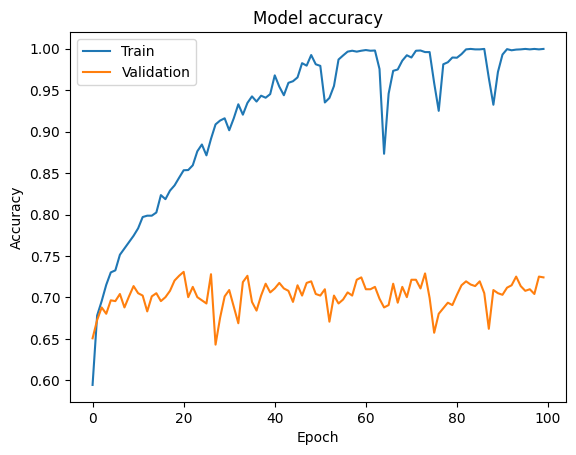

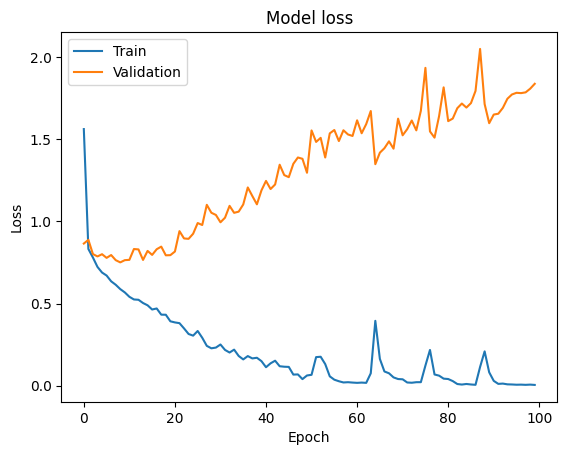

In [11]:
# Show accuracy and loss plots
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [12]:
# Obtain predictions
predicted_class = model.predict(X_test)

predicted_class_probability = np.max(predicted_class, axis=1)*100
predicted_class = np.argmax(predicted_class, axis=1)
true_class = np.argmax(y_test, axis=1)

correct = []
incorrect = []

for i in range(len(predicted_class)):
    if predicted_class[i] == true_class[i]:
        correct.append(i)
    else:
        incorrect.append(i)

print('Correct predictions: ', len(correct))
print('Incorrect predictions: ', len(incorrect))

17/17 [==============================] - 1s 42ms/step
Correct predictions:  382
Incorrect predictions:  143


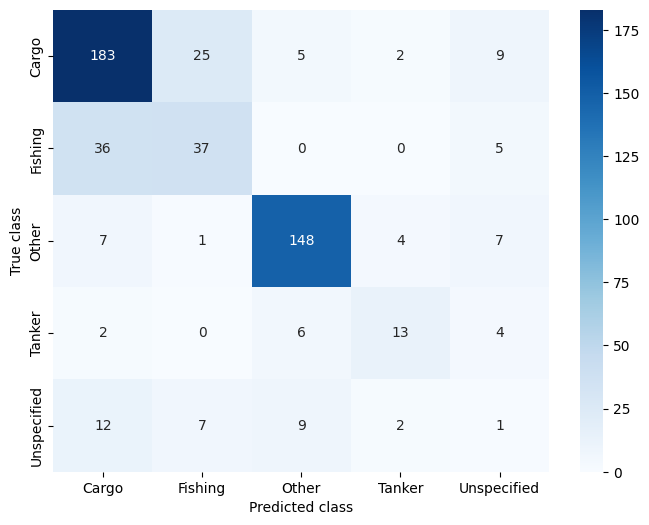

In [13]:
# Show confussion Matrix
cm = confusion_matrix(true_class, predicted_class)
plt.subplots(figsize=(8, 6))
class_names = ['Cargo', 'Fishing', 'Other', 'Tanker', 'Unspecified']
sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues',xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.show()

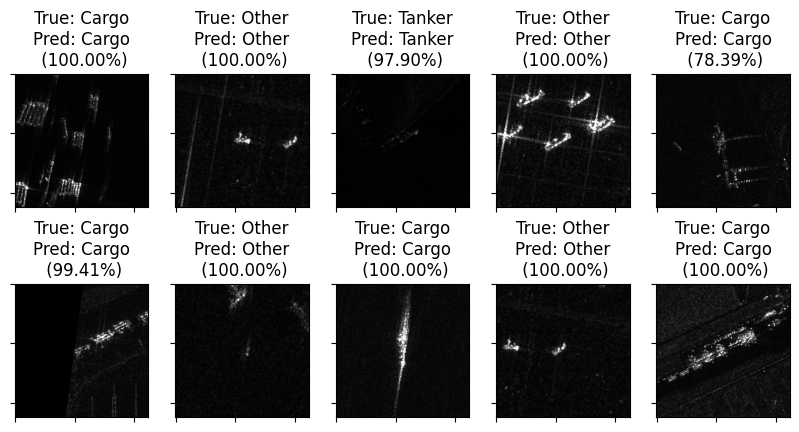

In [14]:
random.shuffle(correct)
random.shuffle(incorrect)

# Show some CORRECT PREDICTIONS
n_rows = 2
n_cols = 5

plt.figure(figsize=(10, 5))
for i in range(n_rows*n_cols):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.imshow(X_test[correct[i]], cmap=plt.get_cmap('gray'))
    plt.title('True: ' + str(text_labels[true_class[correct[i]]]) +
              '\nPred: ' + str(text_labels[predicted_class[correct[i]]]) +
              '\n' + " (%.2f%%)" % predicted_class_probability[correct[i]])


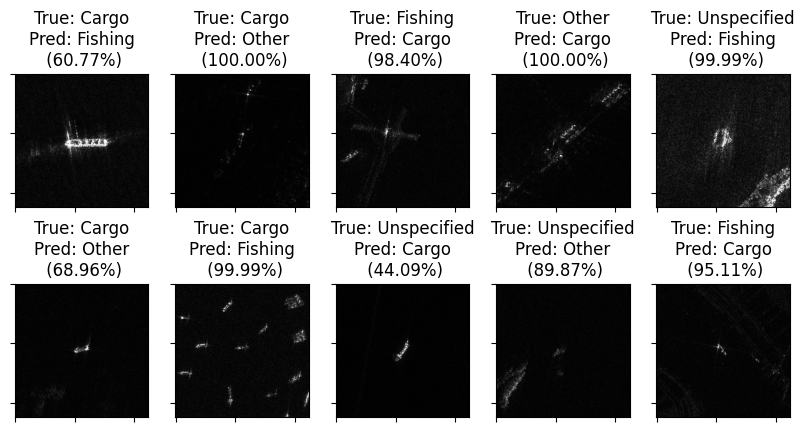

In [15]:
# Show the INCORRECT PREDICTIONS
n_rows = 2
n_cols = 5

plt.figure(figsize=(10,5))
for i in range(n_rows*n_cols):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.imshow(X_test[incorrect[i]], cmap=plt.get_cmap('gray'))
    plt.title('True: ' + str(text_labels[true_class[incorrect[i]]]) +
              '\nPred: ' + str(text_labels[predicted_class[incorrect[i]]]) +
              '\n' + " (%.2f%%)" % predicted_class_probability[incorrect[i]])